<a href="https://colab.research.google.com/github/mamuncseru/deep_understanding_deep_learning/blob/main/DUDL_CodeChallenge_MNIST_reduce7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
from sklearn.model_selection import train_test_split

#New!
import sklearn.metrics as skm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [63]:
data = np.loadtxt(open('sample_data/mnist_train_small.csv', 'rb'), delimiter=',')

In [64]:
# shape of the data matrix
data.shape

(20000, 785)

In [65]:
# extract labels (numbers IDs) and remove from data
labels = data[:, 0]
data = data[:, 1:]

print(labels.shape)
print(data.shape)

(20000,)
(20000, 784)


In [66]:
a = labels == 7
tmpData = data[~a]
tmpLabels = labels[~a]
indx = np.random.randint(0, 1999, 500)
sevens500 = data[a][indx]
sevens500l = labels[a][indx]
data = np.concatenate((tmpData, sevens500), axis=0)
labels = np.concatenate((tmpLabels, sevens500l), axis=0)

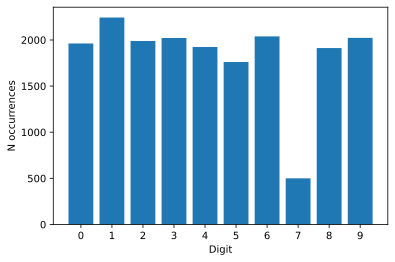

In [67]:
# category counts
catcounts = np.unique(labels, return_counts=True)

# visualize
plt.bar(catcounts[0], catcounts[1])
plt.xlabel('Digit')
plt.ylabel('N occurrences')
plt.xticks(range(10))
plt.show()

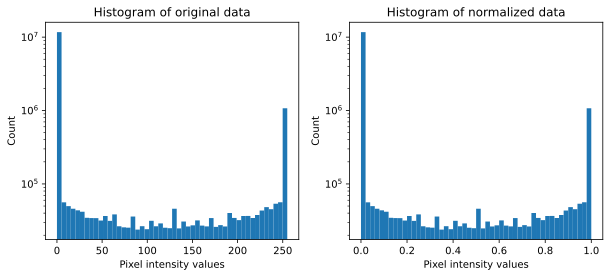

In [68]:
# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(data.flatten(), 50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title("Histogram of original data")
ax[0].set_yscale('log')

ax[1].hist(dataNorm.flatten(), 50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')
ax[1].set_yscale('log')

plt.show()

## Create train/test groups using dataloader

In [69]:
# step 1: convert to tensor
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long() # long = int64

# step 2: use scikit learn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, test_size=.1)

# step 3: convert into pyTorch Datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# step 4: translate into dataloader objects
batchsize = 32
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

## Create the DL model

In [70]:
# create a class for the model

def createTheMNISTNet():

    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            ## input layer
            self.input = nn.Linear(784, 64)

            ## hidden layer
            self.fc1 = nn.Linear(64, 32)
            self.fc2 = nn.Linear(32, 32)

            ## output layer
            self.output = nn.Linear(32, 10)
        
        # forward pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            
            return self.output(x)

        
    net = mnistNet()

    # loss function 
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

    return net, lossfun, optimizer

In [71]:
# test the model with one batch
net, lossfun, optimizer = createTheMNISTNet()

X, y = iter(train_loader).next()
yHat = net(X)
# value s are log-probability of each number (0-9)
print(yHat.shape)
# now let's compute the loss
loss = lossfun(yHat, y)
print(' ')
print('Loss: ')
print(loss)

torch.Size([32, 10])
 
Loss: 
tensor(2.3232, grad_fn=<NllLossBackward0>)


In [72]:
def function2trainTheModel():

    # number of epochs
    numepochs = 10

    # create a new model
    net, lossfun, optimizer = createTheMNISTNet()

    # initialize losses
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    # loop over epochs
    for epochi in range(numepochs):

        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute accuracy
            matches = torch.argmax(yHat, axis=1) == y 
            matchesNumeric = matches.float()
            accuracyPct = 100*torch.mean(matchesNumeric) 
            batchAcc.append(accuracyPct) 

        # end of batch loop

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append(np.mean(batchAcc))

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        X, y = next(iter(test_loader))
        yHat = net(X)

        # compare the following really lon gline of code the training accuracy lines
        testAcc.append(100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()))

    # end epochs
    
    # function output
    return trainAcc, testAcc, losses, net

## Run the model and show the results!

In [73]:
trainAcc, testAcc, losses, net = function2trainTheModel()

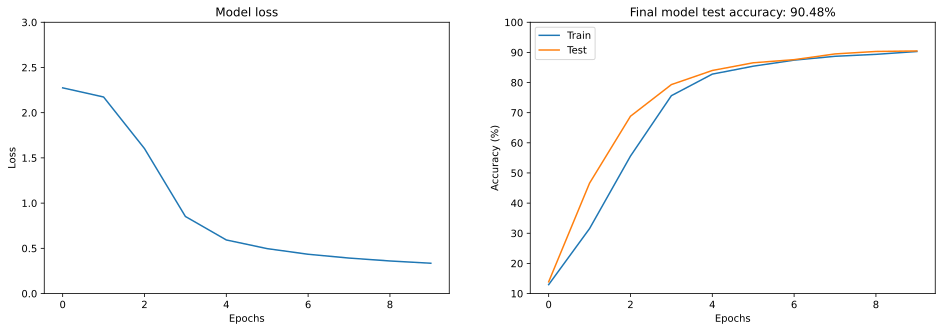

In [74]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0, 3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc, label='Train')
ax[1].plot(testAcc, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].set_ylim([10, 100])
ax[1].legend()

plt.show()

## Compute the performance measures on the train and test data



In [75]:
# predictions for training data
yHat = net(train_loader.dataset.tensors[0])
train_predictions = torch.argmax(yHat, axis=1)

# predictions for test data
yHat = net(test_loader.dataset.tensors[0])
test_predictions = torch.argmax(yHat, axis=1) 
test_predictions

tensor([8, 5, 5,  ..., 4, 6, 5])

In [76]:
# option 1: compute precision for each class (each number)
# skm.precision_score(train_loader.dataset.tensors[1], train_predictions, average=None) 

# # option 2: computer average precision, weighted by N
print(skm.precision_score(train_loader.dataset.tensors[1], train_predictions, average='weighted'))

# # option 3: compute average precision, unweighted (same as 'weighted' if category N's a )
print(skm.precision_score(train_loader.dataset.tensors[1], train_predictions, average='macro'))

0.9084850647815166
0.9058572781864059


In [77]:
#initialize vectors
train_metrics = [0, 0, 0, 0]
test_metrics = [0, 0, 0, 0]

# training
train_metrics[0] = skm.accuracy_score(train_loader.dataset.tensors[1], train_predictions)
train_metrics[1] = skm.precision_score(train_loader.dataset.tensors[1], train_predictions, average='weighted')
train_metrics[2] = skm.recall_score(train_loader.dataset.tensors[1], train_predictions, average='weighted')
train_metrics[3] = skm.f1_score(train_loader.dataset.tensors[1], train_predictions, average='weighted')

# test
test_metrics[0] = skm.accuracy_score(test_loader.dataset.tensors[1], test_predictions)
test_metrics[1] = skm.precision_score(test_loader.dataset.tensors[1], test_predictions, average='weighted')
test_metrics[2] = skm.recall_score(test_loader.dataset.tensors[1], test_predictions, average='weighted')
test_metrics[3] = skm.f1_score(test_loader.dataset.tensors[1], test_predictions, average='weighted')

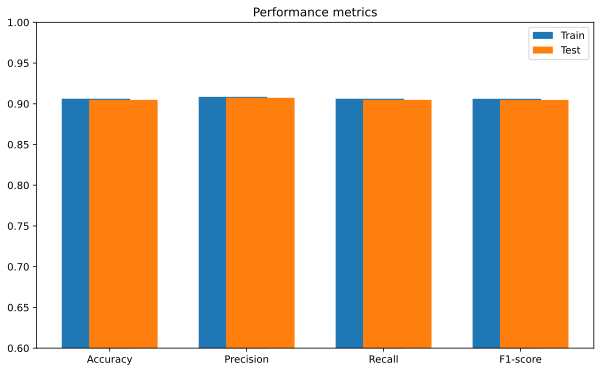

In [78]:
plt.figure(figsize=(10, 6))
plt.bar(np.arange(4)-.1, train_metrics, .5)
plt.bar(np.arange(4)+.1, test_metrics, .5)
plt.xticks([0, 1, 2, 3], ['Accuracy', 'Precision', 'Recall', 'F1-score'])
plt.ylim([.6, 1])
plt.legend(['Train', 'Test'])
plt.title('Performance metrics')
plt.show()

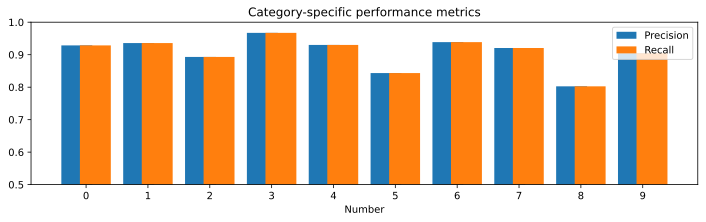

In [79]:
# Bar graphs of class-specific precision and recall for test data

precision = skm.precision_score(test_loader.dataset.tensors[1], test_predictions, average=None)
recall = skm.recall_score(test_loader.dataset.tensors[1], test_predictions, average=None)

fig = plt.figure(figsize=(12, 3))
plt.bar(np.arange(10) - .15, precision, .5)
plt.bar(np.arange(10) + .15, precision, .5)
plt.xticks(range(10), range(10))
plt.ylim([.5, 1])
plt.xlabel('Number')
plt.legend(['Precision', 'Recall'])
plt.title('Category-specific performance metrics')
plt.show()

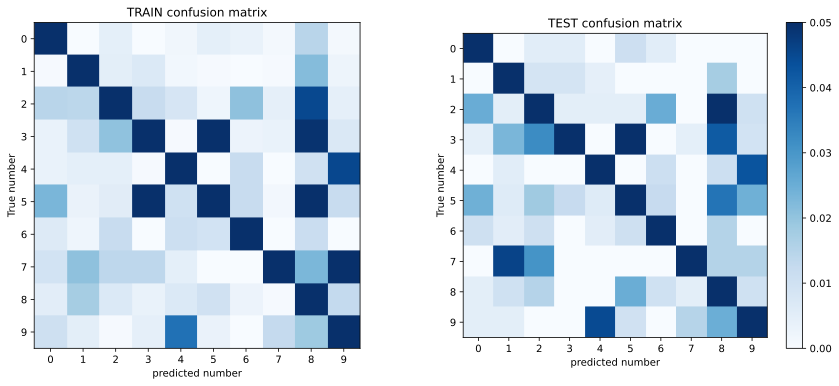

In [80]:
# Confusion matrices
trainConf = skm.confusion_matrix(train_loader.dataset.tensors[1], train_predictions, normalize='true')
testConf = skm.confusion_matrix(test_loader.dataset.tensors[1], test_predictions, normalize='true')

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# confmat during TRAIN
ax[0].imshow(trainConf, 'Blues', vmax=.05)
ax[0].set_xticks(range(10))
ax[0].set_yticks(range(10))
ax[0].set_xlabel('predicted number')
ax[0].set_ylabel('True number')
ax[0].set_title('TRAIN confusion matrix')

#
# confmat during TEST
a = ax[1].imshow(testConf, 'Blues', vmax=.05)
ax[1].set_xticks(range(10))
ax[1].set_yticks(range(10))
ax[1].set_xlabel('predicted number')
ax[1].set_ylabel('True number')
ax[1].set_title('TEST confusion matrix')

fig.colorbar(a)
plt.show()